**Brian Blaylock**  
**December 12, 2018**

# FLAME Equation Method

[FireLine Assessment MEthod (FLAME)](https://www.fs.fed.us/rm/pubs/rmrs_p046/rmrs_p046_027_074.pdf)


- **EWS** - Estimated Wind Speed (miles per hour)
- **ROS** - Rate of Spread (chains per hour. One chain is 66 feet.)

|Type|ROS in `chains/hour`  | EWS correction from 10-m Wind Speed |
|----|--------|--|
| Grass|\begin{equation}ROS_{Grass} = 14.4w^{1.232}\end{equation}| 0.75x|
| Crown|\begin{equation}ROS_{Crown} = 4.87w^{1.146}\end{equation}| 1x|
| Litter|\begin{equation}ROS_{Litter} = 1.03w^{1.213}\end{equation}| 0.25x|

Where `ROS` is the rate of spread in chains/hour and `w` is the EWS in miles/hour.

> ### What is a Chain?
> From Robert Ziel: Chains/hr is an old standard of surveying measure. A chain is 66 feet. 80 chains equals a mile and 10 square chains equals an acre. ft/minute is similar (only about 10% off), so I often think of the output that way.

___

## HRRR Landuse Classification (based on MODIS classification)

A * indicates not in HRRR file

|Value|Label|Fuel|Threshold Burnability<br> (based on soil moisture?)|
|--|--|--|--|
|1|Evergreen Needleleaf forest|Litter/Crown|?|
|2|Evergreen Broadleaf forest|Litter/Crown|?|
|3|Deciduous Needleleaf forest|Litter||
|4|Deciduous Broadleaf forest|Litter||
|5|Mixed forest|Litter/Crown|?|
|6|Closed shrublands|Litter/Crown|?|
|7|Open shrublands|Grass||
|8|Woody savannas|Grass| |
|9|Savannas|Grass||
|10|Grasslands|Grass||
|11|Permanent wetlands|Barrier||
|12|Croplands|Barrier/Grass|?|
|13|Urban and built-up|Barrier||
|14|Cropland/Natural vegetation mosaic|Barrier/Grass|?|
|15|Snow and ice|Barrier| |
|16|Barren or sparsely vegetated|Barrier||
|17|Water|Barrier||
|18|Wooded Tundra|Crown||
|19|Mixed Tundra|Grass| |
|20|*Barren Tundra|Barrier||
|21|*Lake|Barrier||

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_cmap.landuse_colormap import LU_MODIS21
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap

import matplotlib as mpl
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [2]:
m = draw_HRRR_map()
mW = draw_centermap(40, -115, (10,10))          # West
mU = draw_centermap(39.5, -111.6, (3.2,3.2))    # Utah

In [3]:
SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR_fire-ROS/'

# FLAME equations

With the Effective Wind Speed adjustment to the 10-m wind

In [4]:
def ROS(wind_10m, fuel='CROWN', si_units=False, verbose=True):
    '''
    Rate of Spread (ROS) calculations, with an adjustment
    to the effective wind speed (EWS)
    
    Input:
        wind_10m - wind speed at 10-m in m/s
        fuel     - 'CROWN', 'GRASS', 'LITTER', or 'BARRIER'
                   Barrier returns a zero ROS.
        si_units - return ROS in 
    Return:
        ROS in chains/hour (66ft/hour) if si_units==False
            in m/s if si_units==True
    '''
    # Convert wind_10m from m/s to miles/hour
    wind_mph = 2.2369*wind_10m
    
    # Efffective wind speed adjustment
    ews_crown = 1
    ews_grass = .75
    ews_litter = .25
    
    # Equations
    if fuel.upper() == 'CROWN':
        ROS = 4.87 * (wind_mph*ews_crown)**1.146
    elif fuel.upper() == 'GRASS':
        ROS = 14.4 * (wind_mph*ews_grass)**1.232
    elif fuel.upper() == 'LITTER':
        ROS = 1.03 * (wind_mph*ews_litter)**1.213
    elif fuel.upper() == 'BARRIER':
        ROS = wind_mph*0
    else:
        print('fuel arg must be "CROWN", "GRASS", "LITTER", or "BARRIER"')
    
    if si_units:
        # Convert ROS to meters per second
        if verbose:
            print('ROS units in meters per second')
        return ROS*20.1168/3600
    else:
        if verbose:
            print('ROS units in chains per hour')
        return ROS

ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour


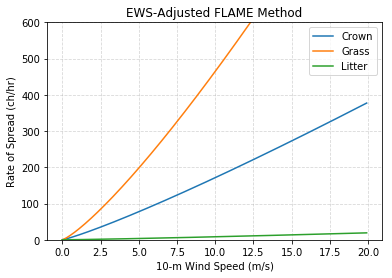

In [5]:
speeds = np.arange(0,20,.1) # 10-m Wind Speed (m/s)
for i in ['Crown', 'Grass', 'Litter']:
    plt.plot(speeds, ROS(speeds, fuel=i), label=i)
plt.ylim(0,600)
plt.legend()

plt.grid(linewidth=.8, linestyle='--', alpha=.5)

plt.title('EWS-Adjusted FLAME Method')
plt.ylabel('Rate of Spread (ch/hr)')
plt.xlabel('10-m Wind Speed (m/s)')

plt.savefig(SAVEDIR+'ROS_for-adjusted-EWS')

# HRRR Landuse

In [6]:
landuse = LU_MODIS21()
landuse.keys()

dict_keys(['cmap', 'labels', 'vmin', 'vmax', 'index'])

In [7]:
validDATE = datetime(2018,7,5,12)
fxx = 12
# HRRR Landuse
H_lu = get_hrrr_variable(validDATE, variable='VGTYP:surface', fxx=fxx, verbose=False)
# Wind Gusts
H = get_hrrr_variable(validDATE-timedelta(hours=fxx), variable='GUST:surface', fxx=fxx, verbose=False)

7.034% for Evergreen Needleleaf Forest
0.671% for Evergreen Broadleaf Forest
0.004% for Deciduous Needleleaf Forest
3.334% for Deciduous Broadleaf Forest
7.862% for Mixed Forests
0.713% for Closed Shrublands
11.075% for Open Shrublands
2.309% for Woody Savannas
0.257% for Savannas
10.948% for Grasslands
0.000% for Permanent Wetlands
16.763% for Croplands
0.766% for Urban and Built-Up
0.000% for Cropland/Natural Vegetation Mosaic
0.008% for Snow and Ice
0.602% for Barren or Sparsely Vegetated
37.588% for Water
0.066% for Wooded Tundra
0.000% for Mixed Tundra
0.000% for Barren Tundra
0.000% for Lake


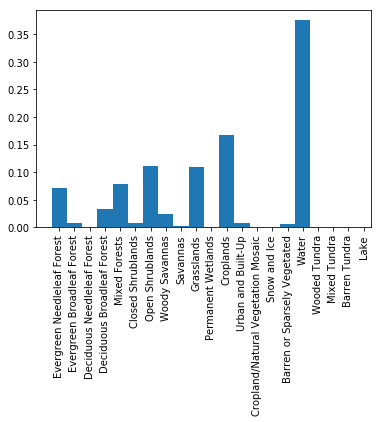

In [8]:
a = plt.hist(H_lu['value'].flatten(), bins=landuse['index'], density=True)
plt.xticks(np.array(landuse['index'])+.5, landuse['labels'],rotation=90);
plt.grid
plt.savefig(SAVEDIR+'HRRR_landuse_histogram')

# Percentage of each land use category
for i, index in enumerate(landuse['index']):
    count = np.sum(H_lu['value']==index)
    print('%2.3f%% for %s' % (100*count/np.size(H['value']), landuse['labels'][i]))
    

## HRRR Landuse

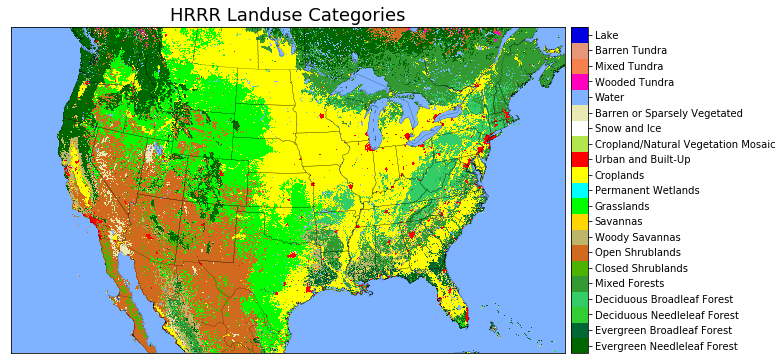

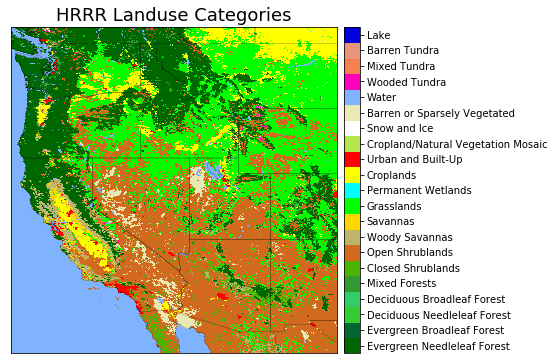

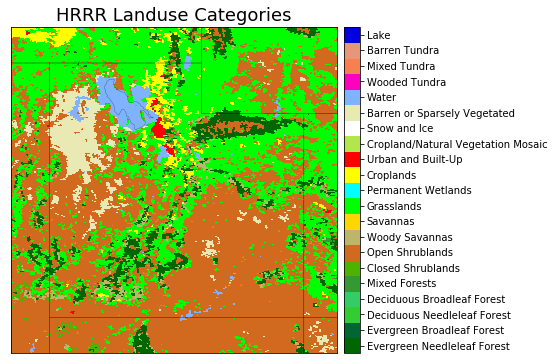

In [9]:
def plot_HRRR_landuse(m, domain='CONUS'):
    plt.figure(figsize=[12,6])
    m.pcolormesh(H_lu['lon'], H_lu['lat'], H_lu['value'],
              cmap=landuse['cmap'],
              vmax=landuse['vmax'], vmin=landuse['vmin'],
              latlon=True,)
    m.drawcoastlines(linewidth=.2)
    m.drawstates(linewidth=.2)
    m.drawcountries(linewidth=.2)
    cbar = plt.colorbar(pad=.01)
    cbar.set_ticks(np.arange(0.5, len(landuse['labels']) + 1))
    cbar.ax.set_yticklabels(landuse['labels'])

    plt.title('HRRR Landuse Categories', fontsize=18)
    plt.savefig(SAVEDIR+'HRRR_%s_landuse' % domain)

plot_HRRR_landuse(m, 'CONUS')
plot_HRRR_landuse(mW, 'WEST')
plot_HRRR_landuse(mU, 'UTAH')

## Estimated Fuel Types
Effective wind speed adjustment to land use

In [10]:
fuel_type = [(1, 'CROWN'),
             (2, 'CROWN'),
             (3, 'LITTER'),
             (4, 'LITTER'),
             (5, 'CROWN'),
             (6, 'CROWN'),
             (7, 'GRASS'),
             (8, 'GRASS'),
             (9, 'GRASS'),
             (10, 'GRASS'),
             (11, 'BARRIER'),
             (12, 'GRASS'),
             (13, 'BARRIER'),
             (14, 'GRASS'),
             (15, 'BARRIER'),
             (16, 'BARRIER'),
             (17, 'BARRIER'),
             (18, 'CROWN'),
             (19, 'GRASS'),
             (20, 'BARRIER'),
             (21, 'BARRIER'),
            ]

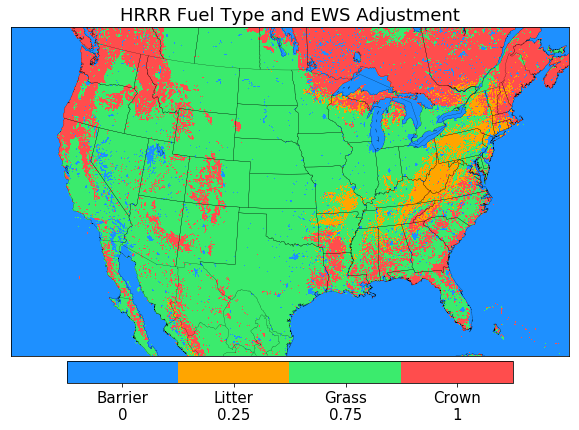

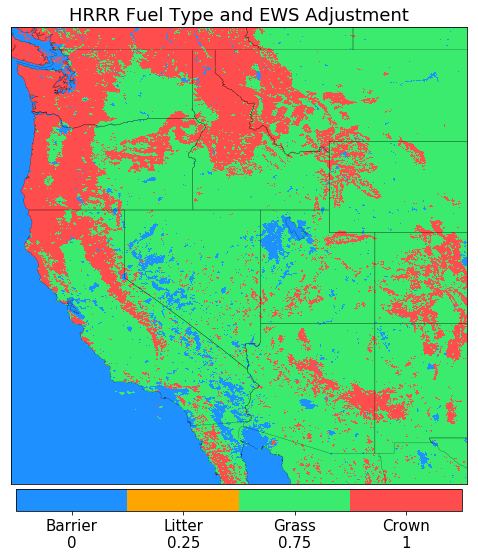

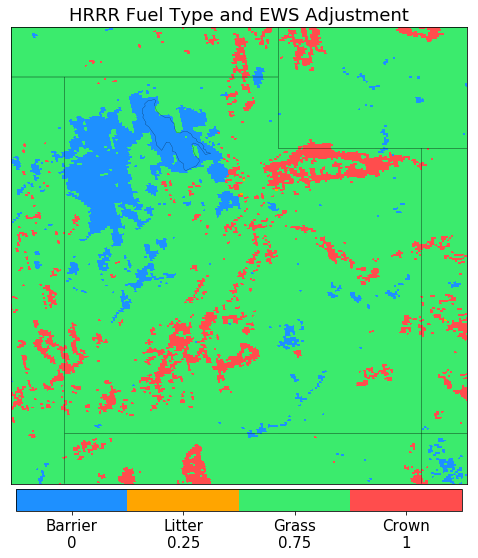

In [11]:
from matplotlib import colors as c
cm_fuel, norm = c.from_levels_and_colors([0, .25, .75, 1, 1.25], ['dodgerblue', 'orange', '#3beb6d', '#ff4d4d'])

ews_adjust = np.zeros_like(H_lu['value'])
ews_adjusted = np.zeros_like(H_lu['value'])

for lu_idx, fuel in fuel_type:
    if fuel == 'CROWN':
        ews_adjust[H_lu['value']==lu_idx] = 1
        ews_adjusted[H_lu['value']==lu_idx] = H['value'][H_lu['value']==lu_idx]*1
    elif fuel == 'GRASS':
        ews_adjust[H_lu['value']==lu_idx] = .75
        ews_adjusted[H_lu['value']==lu_idx] = H['value'][H_lu['value']==lu_idx]*.75
    elif fuel == 'LITTER':
        ews_adjust[H_lu['value']==lu_idx] = .25
        ews_adjusted[H_lu['value']==lu_idx] = H['value'][H_lu['value']==lu_idx]*.25
    elif fuel == 'BARRIER':
        ews_adjust[H_lu['value']==lu_idx] = 0
        ews_adjusted[H_lu['value']==lu_idx] = H['value'][H_lu['value']==lu_idx]*0

def plot_HRRR_fuel(m, domain='CONUS'):
    plt.figure(figsize=[10,10])
    m.pcolormesh(H['lon'], H['lat'], ews_adjust,
                 norm=norm,
                 cmap=cm_fuel,
                 latlon=True,)
    m.drawcoastlines(linewidth=.2)
    m.drawstates(linewidth=.2)
    m.drawcountries(linewidth=.2)
    cbar = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.8,
                        ticks=[.25/2, .5, .75/2+.5, 1+.25/2]
                       )
    cbar.ax.set_xticklabels(['Barrier\n0', 'Litter\n0.25', 'Grass\n0.75', 'Crown\n1'], fontsize=15)

    plt.title('HRRR Fuel Type and EWS Adjustment', fontsize=18)

    plt.savefig(SAVEDIR+'HRRR_%s_fuel_type' % domain)

plot_HRRR_fuel(m, 'CONUS')
plot_HRRR_fuel(mW, 'WEST')
plot_HRRR_fuel(mU, 'UTAH')

## Effective Wind Speed

<Figure size 864x864 with 0 Axes>

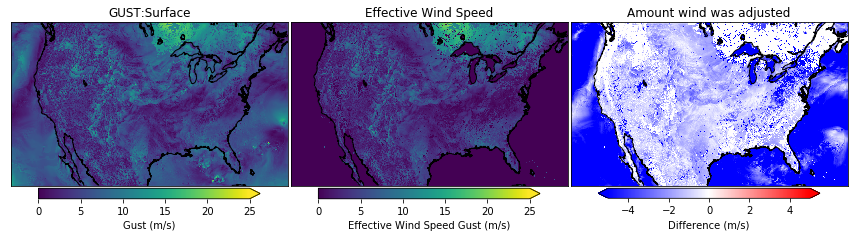

In [12]:
plt.figure(figsize=[12,12])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15,5])
plt.sca(ax1)
m.pcolormesh(H['lon'], H['lat'], H['value'], vmin=0, vmax=25, latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8, label='Gust (m/s)', extend='max')
plt.title('GUST:Surface')

plt.sca(ax2)
m.pcolormesh(H['lon'], H['lat'], ews_adjusted, vmin=0, vmax=25, latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8, label='Effective Wind Speed Gust (m/s)', extend='max')
plt.title('Effective Wind Speed')

plt.sca(ax3)
m.pcolormesh(H['lon'], H['lat'], ews_adjusted-H['value'], cmap='bwr', vmin=-5, vmax=5, latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8, label='Difference (m/s)', extend='both')
plt.title('Amount wind was adjusted')

plt.subplots_adjust(wspace=.01)

plt.savefig(SAVEDIR+'HRRR_GustAdjustment_%s_f%02d' % (H['anlys'].strftime('%Y%m%d-%H%M'), H['fxx']))

## Rate of Spread

ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour
ROS units in chains per hour


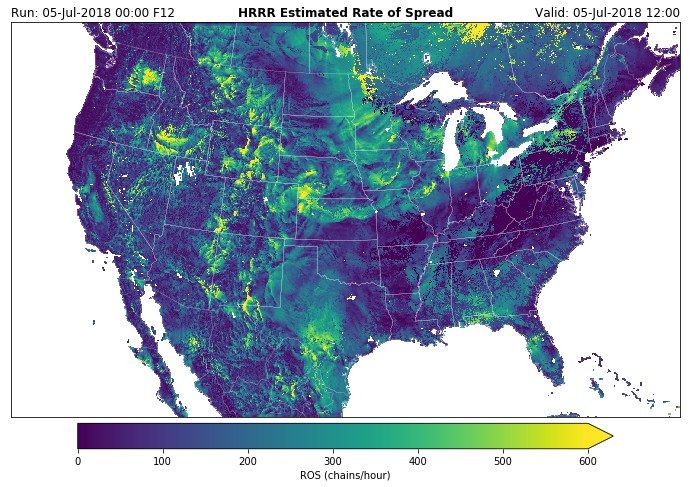

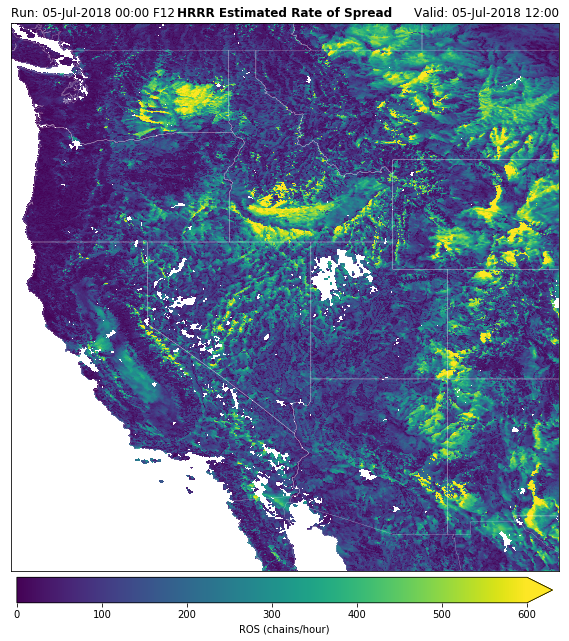

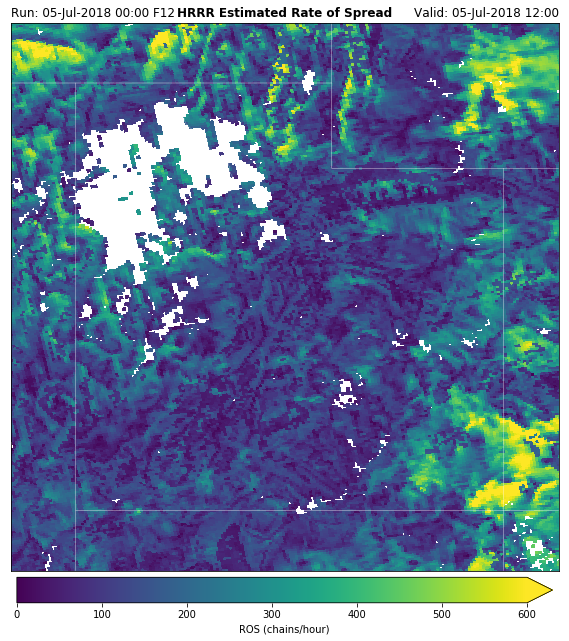

In [13]:
ews = np.zeros_like(H_lu['value'])
for (lu_idx, fuel) in fuel_type:
    ews[H_lu['value']==lu_idx] = ROS(H['value'][H_lu['value']==lu_idx], fuel)

masked = np.ma.masked_array(ews, mask=ews==0)
    
def plot_ROS(m, domain='CONUS'):
    plt.figure(figsize=[12,12])
    m.pcolormesh(H['lon'], H['lat'], masked, latlon=True, vmax=600, vmin=0)
    m.drawcoastlines(linewidth=.2, color='w')
    m.drawstates(linewidth=.2, color='w')
    m.drawcountries(linewidth=.2, color='w')

    plt.colorbar(orientation='horizontal', pad=0.01, shrink=.8, label='ROS (chains/hour)', extend='max')

    plt.title('HRRR Estimated Rate of Spread', fontweight='semibold')
    plt.title('Run: %s F%02d' % (H['anlys'].strftime('%d-%b-%Y %H:%M'),H['fxx']), loc='left')
    plt.title('Valid: %s' % H['valid'].strftime('%d-%b-%Y %H:%M'), loc='right')

    plt.savefig(SAVEDIR+'HRRR_ROS_%s_%s_f%02d' % (domain, H['anlys'].strftime('%Y%m%d-%H%M'), H['fxx']))

plot_ROS(m, 'CONUS')
plot_ROS(mW, 'WEST')
plot_ROS(mU, 'UTAH')